In [46]:
%pylab
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from rtlsdr import RtlSdr
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [47]:
sdr = RtlSdr()
F_station = int(88.1e6)  # Pick a radio station  
F_offset = 250000         # Offset to capture at  
Fc = F_station - F_offset # Capture center frequency  
Fs = 1140000         # Sample rate  
N = 8192000           # Samples to capture  
# configure device
sdr.sample_rate = Fs      # Hz  
sdr.center_freq = Fc      # Hz  
sdr.gain = 'auto'

In [48]:
# Read samples
samples = sdr.read_samples(N)
sdr.close()  
del(sdr)

In [49]:
x1 = np.array(samples).astype("complex64")
# To mix the data down, generate a digital complex exponential 
# (with the same length as x1) with phase -F_offset/Fs
fc1 = np.exp(-1.0j*2.0*np.pi* F_offset/Fs*np.arange(len(x1)))  
# Now, just multiply x1 and the digital complex expontential
x2 = x1 * fc1  

# An FM broadcast signal has  a bandwidth of 200 kHz
f_bw = 200000  
n_taps = 64  
# Use Remez algorithm to design filter coefficients
lpf = signal.remez(n_taps, [0, f_bw, f_bw+(Fs/2-f_bw)/4, Fs/2], [1,0], Hz=Fs)  
x3 = signal.lfilter(lpf, 1.0, x2)

dec_rate = int(Fs / f_bw)  
x4 = x3[0::dec_rate]  
# Calculate the new sampling rate
Fs_y = Fs/dec_rate  

### Polar discriminator
y5 = x4[1:] * np.conj(x4[:-1])  
x5 = np.angle(y5)  

# The de-emphasis filter
# Given a signal 'x5' (in a numpy array) with sampling rate Fs_y
d = Fs_y * 75e-6   # Calculate the # of samples to hit the -3dB point  
x = np.exp(-1/d)   # Calculate the decay between each sample  
b = [1-x]          # Create the filter coefficients  
a = [1,-x]  
x6 = signal.lfilter(b,a,x5)  

# Find a decimation rate to achieve audio sampling rate between 44-48 kHz
audio_freq = 44100.0  
dec_audio = int(Fs_y/audio_freq)  
Fs_audio = Fs_y / dec_audio

x7 = signal.decimate(x6, dec_audio)  

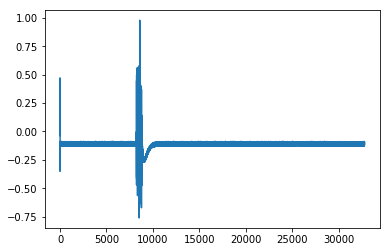

In [50]:
plt.plot(x7[::10])

In [51]:
def smooth(x,window_len=11,window='hanning'):
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

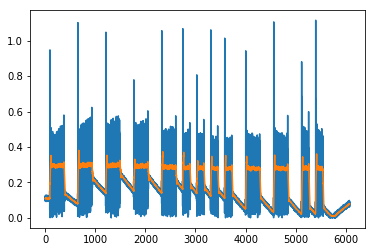

In [52]:
x8 = x7[1000:]
smoothed = smooth(np.abs(x8), window_len=21, window='flat')
start_threshold = .25
start = 0
for i, s in enumerate(smoothed):
    if s > start_threshold:
        start = i - 100
        break
        
baud = 300
samp_per_bit = Fs_audio/baud
n_bits = 20

stop = start + int(2 * samp_per_bit * n_bits)
plt.plot(np.abs(x8)[start:stop])
plt.plot(smoothed[start:stop])

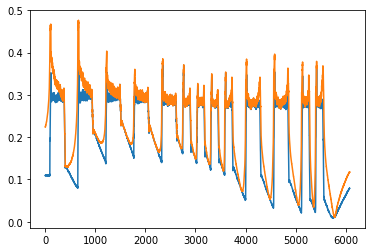

In [53]:
smoothed = smoothed[start:stop]
analytical_signal = signal.hilbert(smooth(np.abs(x8), window_len=21, window='flat'))[start:stop]
envelope = np.abs(analytical_signal)
plt.plot(smoothed)
plt.plot(envelope)

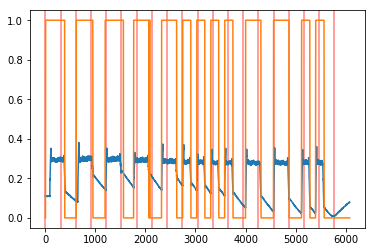

In [54]:
avg = np.average(envelope)
sliced = [1 if x > avg else 0 for x in envelope]

vlines = [2*i*samp_per_bit for i in range(20)]
for vline in vlines:
    plt.axvline(x=vline, color='r', alpha=.5)
plt.plot(smoothed)
plt.plot(sliced)

In [55]:
transitions = []
for i in range(len(sliced)-1):
    if sliced[i] == 1 and sliced[i+1] == 0:
        transitions.append((i, 0))
    if sliced[i] == 0 and sliced[i+1] == 1:
        transitions.append((i, 1))


valid_transitions = [transitions[0]]
threshold = samp_per_bit / 1.2
for t, b in transitions[1:]:
    if np.abs(valid_transitions[-1][0] + (2*samp_per_bit) - t) < threshold:
        valid_transitions.append((t, b))

bits = [b for _, b in valid_transitions]
print(bits)

[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]


In [ ]:
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]